In [1]:
import jupyter_black
%load_ext jupyter_black

In [2]:
import warnings

warnings.filterwarnings("ignore")

<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
# Radar - Sentinel-1: ARD SAR Backscatter

This notebook has been duplicated from an existing sample processing pipeline for Radar ARD on the openEO platform. In this instance, we aim to showcase it with the Copernicus Data Space Ecosystem backend.

For more information [click here](https://docs.openeo.cloud/usecases/ard/).ess

## Setup

Import the `openeo` package and connect to the Copernicus Data Space Ecosystem openEO back-end.

In [3]:
import openeo

In [4]:
backend = "openeo.dataspace.copernicus.eu"
conn = openeo.connect(backend).authenticate_oidc()

Authenticated using refresh token.


### On-demand SAR Backscatter

Data from synthetic aperture radar (SAR) sensors requires significant preprocessing to be calibrated and normalized. This is referred to as backscatter computation and is provided in the openEO by the [`sar_backscatter` process](https://docs.openeo.cloud/processes/#sar_backscatter).

The radiometric correction coefficient used in this example is `sigma0-ellipsoid`.

## Specify area of interest, temporal extent, polarization

In [5]:
collection = "SENTINEL1_GRD"
spatial_extent = {
    "west": 11.293602,
    "east": 11.382866,
    "south": 46.460163,
    "north": 46.514768,
    "crs": "EPSG:4326",
}
temporal_extent = ["2021-01-01", "2021-01-08"]
bands = ["VV", "VH"]

properties = {"orbitDirection": lambda od: od == "ASCENDING"}

## Orbit direction filtering

s1 = conn.load_collection(
    collection,
    spatial_extent=spatial_extent,
    bands=bands,
    temporal_extent=temporal_extent,
    properties=properties,
)

## Apply openEO processes

Here we apply both the SAR backscattering processes on the datacube and then convert it from linear to dB scale.

In [7]:
s1_scatter = s1.sar_backscatter(
    coefficient="sigma0-ellipsoid", elevation_model="COPERNICUS_30"
)
s1bs = s1_scatter.apply(lambda x: 10 * x.log(base=10))

## Synchronous execution 

If our area of interest is small, a direct request is possible, but this will not return the JSON metadata.

Note that this step automatically adds the save_result process at the end based on the output format we choose.

In [8]:
%time s1bs.download("sar_bs.nc")

CPU times: user 14 ms, sys: 15.8 ms, total: 29.8 ms
Wall time: 1min 11s


## Batch job-based execution

Another method available for large-scale process execution is using Batch job. The easiest way to run our processing as a batch job is using the execute_batch() helper, which takes care of creating a batch job, starting it, and polling its status until it's finished (or failed).

While not necessary, it is recommended to give your batch job a descriptive title so it’s easier to identify in your job listing.

In [12]:
s1bs = s1bs.save_result(format="NetCDF")
job = s1bs.execute_batch(title="Sentinel-1 ARD")

0:00:00 Job 'j-268a65526d7543f5889d267d25ca55ae': send 'start'
0:00:14 Job 'j-268a65526d7543f5889d267d25ca55ae': created (progress N/A)
0:00:20 Job 'j-268a65526d7543f5889d267d25ca55ae': created (progress N/A)
0:00:26 Job 'j-268a65526d7543f5889d267d25ca55ae': created (progress N/A)
0:00:35 Job 'j-268a65526d7543f5889d267d25ca55ae': created (progress N/A)
0:00:48 Job 'j-268a65526d7543f5889d267d25ca55ae': running (progress N/A)
0:01:02 Job 'j-268a65526d7543f5889d267d25ca55ae': running (progress N/A)
0:01:17 Job 'j-268a65526d7543f5889d267d25ca55ae': running (progress N/A)
0:01:37 Job 'j-268a65526d7543f5889d267d25ca55ae': running (progress N/A)
0:02:01 Job 'j-268a65526d7543f5889d267d25ca55ae': finished (progress N/A)


Get a description of the job and check its status.

Once the status is 'finished', it is possible to inspect the results. Download links are provided to retrieve data and metadata.

In [24]:
# job("j-268a65526d7543f5889d267d25ca55ae")           # inspect job if needed


results = job_bs.get_results()                        # inspect the result
results

<JobResults for job 'j-757f525b553d4cd087ae4f8df0f05769'>

**Optional: download complete result with metadata and source files**

Results contain STAC metadata and the processed data. 

We can simply download everything, for inspection. Please note: this will download also the original S1 GRD files, which can take a lot of time for a big area or a timeseries.

In [ ]:
# results.download_files()

## Output visualization

In [9]:
import xarray as xr

S1_ard = xr.open_dataset("sar_bs.nc")
S1_ard

<xarray.Dataset>
Dimensions:  (t: 1, x: 704, y: 628)
Coordinates:
  * t        (t) datetime64[ns] 2021-01-03
  * x        (x) float64 6.759e+05 6.76e+05 6.76e+05 ... 6.83e+05 6.83e+05
  * y        (y) float64 5.154e+06 5.154e+06 5.154e+06 ... 5.148e+06 5.148e+06
Data variables:
    crs      |S1 ...
    VV       (t, y, x) float32 ...
    VH       (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

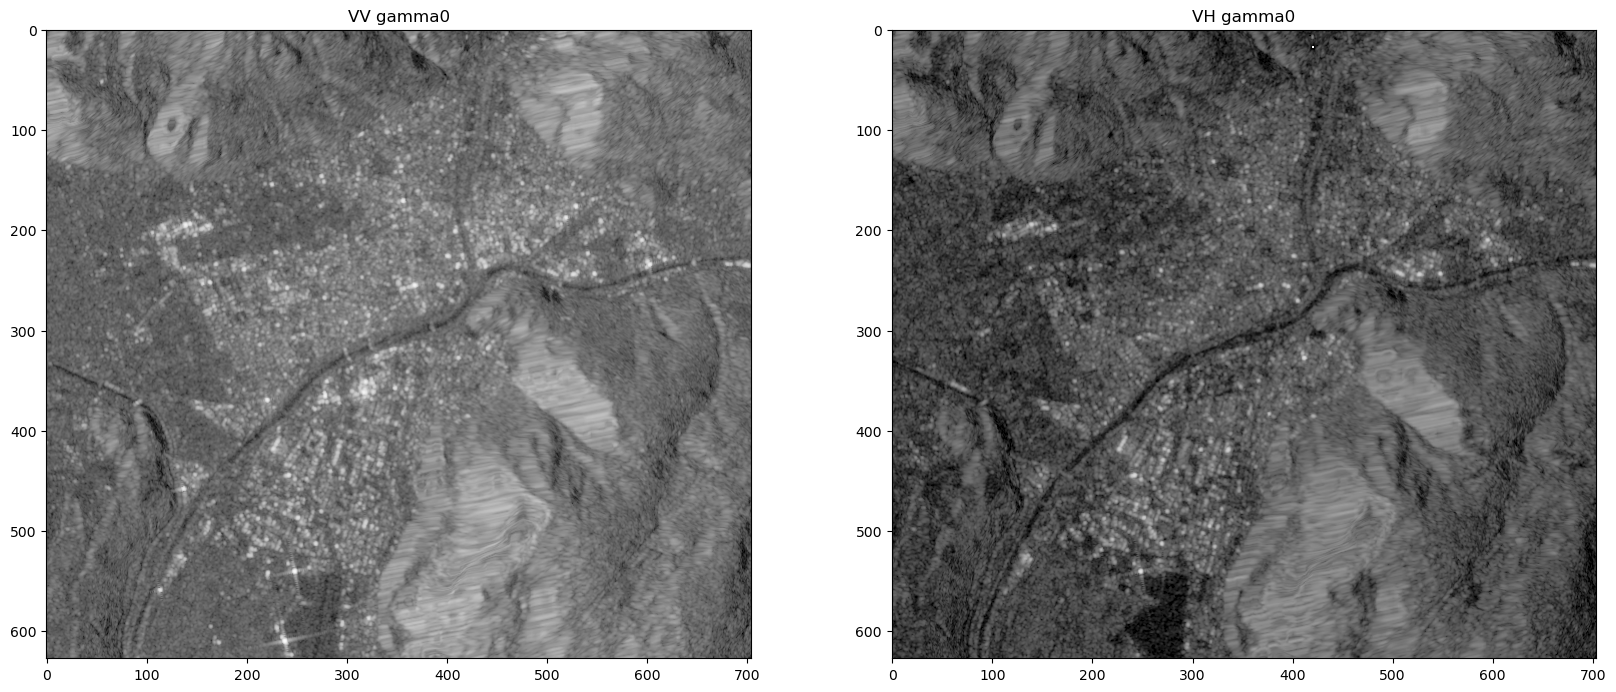

In [10]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(S1_ard.VV[0].values, cmap="Greys_r", vmin=-30, vmax=30)
ax1.set_title("VV gamma0")
ax2.imshow(S1_ard.VH[0].values, cmap="Greys_r", vmin=-30, vmax=30)
ax2.set_title("VH gamma0")
plt.show()